## CDF of mis-registration

In [1]:
%matplotlib inline
import os
import string
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt, ticker, patches
from mintpy.objects import timeseries, sensor
from mintpy.utils import readfile, utils as ut
from ipynb.fs.full import utils
plt.rcParams.update({'font.size': 12})

work_dir = os.path.expanduser('~/Papers/2021_Geolocation/figs_src/stats')
os.chdir(work_dir)
print('Go to directory:', work_dir)

proj_dirs = [os.path.expanduser('~/data/geolocation/ChileSenAT149/mintpy_offset'),
             os.path.expanduser('~/data/geolocation/ChileSenDT156/mintpy_offset'),
             os.path.expanduser('~/data/geolocation/KyushuAlos2DT23/mintpy_offset')]

Go to directory: /Users/yunjunz/Papers/2021_Geolocation/figs_src/stats


### Calculate

In [2]:
# read from HDF5 file
ts_S1_list = [[], [], [], []]
ts_A2_list = [[], [], [], []]
for proj_dir in proj_dirs:
    suffix = '' if 'Alos2' in proj_dir else '_S1Bias'
    fnames = [os.path.join(proj_dir, f'timeseriesRg{suffix}.h5'),
              os.path.join(proj_dir, f'timeseriesRg{suffix}_TECjhr.h5'),
              os.path.join(proj_dir, f'timeseriesRg{suffix}_TECjhr_SET.h5'),
              os.path.join(proj_dir, f'timeseriesRg{suffix}_TECjhr_SET_ERA5.h5')]
    tsDict = utils.read_ts_files(fnames, print_msg=False, print_max=False)[1]
    for i, ts in enumerate(tsDict.values()):
        if 'Sen' in proj_dir:
            ts_S1_list[i] += ts.tolist()
        else:
            ts_A2_list[i] += ts.tolist()

# calculate CDF
# link: https://stackoverflow.com/questions/24788200/calculate-the-cumulative-distribution-function-cdf-in-python
num_S1 = len(ts_S1_list[0])
num_A2 = len(ts_A2_list[0])
p_S1 = 100. * np.arange(num_S1) / (num_S1 - 1)
p_A2 = 100. * np.arange(num_A2) / (num_A2 - 1)

print('max residual for S1: {:.2f} m'.format(np.nanmax(np.abs(ts_S1_list[-1]))))
print('max residual for A2: {:.2f} m'.format(np.nanmax(np.abs(ts_A2_list[-1]))))

max residual for S1: 0.25 m
max residual for A2: 1.64 m


### Plot

save figure to file /Users/yunjunz/Papers/2021_Geolocation/figs_src/stats/stats_cdf.pdf


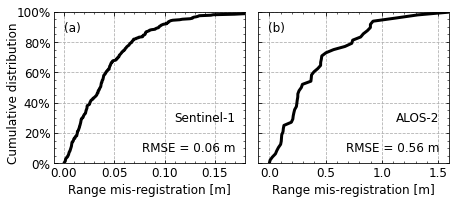

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[6.5, 3], sharey=True)
labels = ['w/o ancillary refine', 'w/ ancillary refine']
#axs[0].plot(ts_pre_S1,  p_S1, label=labels[0], lw=2)
#axs[1].plot(ts_pre_A2,  p_A2, label=labels[0], lw=2)
#axs[0].hist(ts_S1_list[-1], bins=20, range=(0, 0.2), density=True)
#axs[1].hist(ts_A2_list[-1], bins=10, range=(0, 2.1), density=True)
axs[0].plot(np.sort(np.abs(ts_S1_list[-1])), p_S1, label=labels[1], lw=3, color='k')
axs[1].plot(np.sort(np.abs(ts_A2_list[-1])), p_A2, label=labels[1], lw=3, color='k')

# axis format
axs[0].set_xlim(-0.01, 0.18)
axs[1].set_xlim(-0.10, 1.6)
for ax in axs:
    ax.tick_params(which='both', direction='in', top=True, bottom=True, left=True, right=True)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
    ax.set_ylim(0, 100)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.grid('on', linestyle='--')
    ax.set_xlabel('Range mis-registration [m]')
axs[0].set_ylabel('Cumulative distribution', labelpad=-4, loc='bottom')
for ax, num in zip(axs, ['(a)', '(b)']):  ax.annotate(num, xy=(0.05, 0.87), xycoords='axes fraction', ha='left')
std_S1 = ut.root_mean_sq_error(ts_S1_list[-1]) #np.std(ts_S1_list[-1])
std_A2 = ut.root_mean_sq_error(ts_A2_list[-1]) #np.std(ts_A2_list[-1])
for ax, title in zip(axs, ['Sentinel-1\n\nRMSE = {:.2f} m'.format(std_S1), 'ALOS-2\n\nRMSE = {:.2f} m'.format(std_A2)]):
    ax.annotate(title, xy=(0.95, 0.08), xycoords='axes fraction', ha='right')

fig.tight_layout()
# output
out_fig = os.path.join(work_dir, 'stats_cdf.pdf')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Implication for Stack Coregistration

In [6]:
# Conclusion for stack coregistration - S1
s1_ts = ts_S1_list[-1]
s1_num = len(s1_ts)
s1_rg_std = np.std(s1_ts)  # Yunjun et al. [in prep]
s1_az_std = 0.36                          # Gisinger et al. (2021)
s1_rg_std_pix = s1_rg_std * 2 / sensor.SENSOR_DICT['sen']['range_pixel_size']
s1_az_std_pix = s1_az_std * 2 / sensor.SENSOR_DICT['sen']['azimuth_pixel_size']
print(f'S1 ({s1_num} images) - rg: {s1_rg_std:.2f} m (1-sigma) / {s1_rg_std_pix:.2f} pixel (2-sigma)')
print(f'S1 ({s1_num} images) - az: {s1_az_std:.2f} m (1-sigma) / {s1_az_std_pix:.2f} pixel (2-sigma)')

S1 (304 images) - rg: 0.06 m (1-sigma) / 0.05 pixel (2-sigma)
S1 (304 images) - az: 0.36 m (1-sigma) / 0.05 pixel (2-sigma)


In [7]:
# Conclusion for stack coregistration - ALOS-2
a2_sub = 0.311  # from Table III

a2_ts = ts_A2_list[-1]
a2_num = len(a2_ts)
a2_rg_std = np.std(a2_ts)  # Yunjun et al. [in prep]
for rg_std in [a2_rg_std, a2_sub]:
    rg_std_pix_a1 = rg_std / sensor.SENSOR_DICT['alos']['range_pixel_size']['stripmap_FBD']
    rg_std_pix_a2 = rg_std / sensor.SENSOR_DICT['alos2']['range_pixel_size']['stripmap_ultrafine']
    rg_std_pix_ni = rg_std / sensor.SENSOR_DICT['ni']['range_pixel_size']['24MHz']
    print(f'ALOS-2 ({a2_num} images) - rg: {rg_std:.2f} m (1-sigma)')
    print('ALOS  - rg: {:.2f} pixel (1-sigma)'.format(rg_std_pix_a1))
    print('ALOS2 - rg: {:.2f} pixel (1-sigma)'.format(rg_std_pix_a2))
    print('NISAR - rg: {:.2f} pixel (1-sigma)'.format(rg_std_pix_ni))
    print('')

ALOS-2 (49 images) - rg: 0.55 m (1-sigma)
ALOS  - rg: 0.06 pixel (1-sigma)
ALOS2 - rg: 0.38 pixel (1-sigma)
NISAR - rg: 0.09 pixel (1-sigma)

ALOS-2 (49 images) - rg: 0.31 m (1-sigma)
ALOS  - rg: 0.03 pixel (1-sigma)
ALOS2 - rg: 0.22 pixel (1-sigma)
NISAR - rg: 0.05 pixel (1-sigma)



### Backup - an alternative to the boxenplot to summarize geolocation bias correction

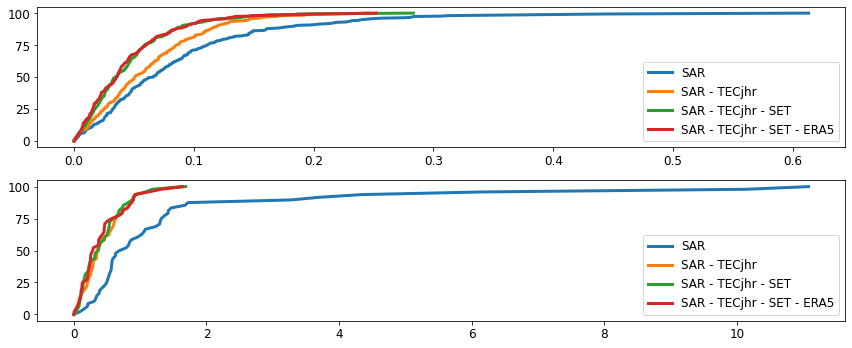

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[12, 5], sharey=True)
for i, (ts_S1, ts_A2) in enumerate(zip(ts_S1_list, ts_A2_list)):
    axs[0].plot(np.sort(np.abs(ts_S1)), p_S1, lw=3, label=list(tsDict.keys())[i])
    axs[1].plot(np.sort(np.abs(ts_A2)), p_A2, lw=3, label=list(tsDict.keys())[i])
for ax in axs:  ax.legend()

fig.tight_layout()
# output
plt.show()